In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cnfg
import re
import os
from sqlalchemy import create_engine
from gensim import corpora, models, similarities, matutils
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import logging
from sklearn.decomposition import TruncatedSVD, NMF

# logging for gensim (set to INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

In [2]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
                        config['db_user'],
                        config['db_pwd'],
                        config['db_host'],
                        'sephora'))

query_product = """SELECT * FROM sephora_product WHERE category IN ('moisturizers', 'face serums', 'face wash & cleansers',
         'eye creams & treatments', 'face masks', 'moisturizer & treatments',
         'face oils')"""
df_product = pd.read_sql_query(query_product, engine)
# df_product = pd.read_csv('data/sephora_product.csv')
df_product = df_product.set_index('id')
df_product.head(3)

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price
id,,,,,,,,,
P102503,/wrinkle-revenge-rescue-protect-facial-cream-P...,844480,moisturizers,DERMAdoctor,Wrinkle Revenge Rescue & Protect Facial Cream,4.2366,What it is:A lightweight concentrate that deli...,1.7,57
P102504,/wrinkle-revenge-eye-balm-P102504,844472,eye creams & treatments,DERMAdoctor,Wrinkle Revenge Eye Balm,4.0591,What it is:A super-hydrating eye balm enriched...,0.5,50
P107306,/renewing-eye-cream-P107306,769836,eye creams & treatments,Murad,Renewing Eye Cream,4.0706,"What it is: A multiactive, antiaging treatment...",0.5,80


In [3]:
query_review = 'SELECT * FROM sephora_product_review'
df = pd.read_sql_query(query_review, engine)
# df = pd.read_csv('data/sephora_review.csv')
# df = df[df.rating <= 3]
df = df.set_index('review_id')
df.head()

,product_id,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags
review_id,,,,,,,,,,
4e36532f-3fb6-4bdb-b60a-ffb2e0bce24a,P382355,awesome moisturizer,"I usually don't write reviews, but this produc...",5,None,None,None,None,jhpv,None
276eea61-917b-4242-bc28-ce1b82bf4238,P382355,HYDRATOR/MOISTURIZER,this one is a little gem. Would have never com...,5,None,combination,None,None,sweetipy,"[hydrating, moisturizing]"
a9a3c78e-c151-4dba-8f0c-b8fcc8d1cd7b,P382355,,"i had high hopes after reading the reviews, an...",2,None,normal,None,None,lsutiger,"[hydrating, moisturizing]"
7391220f-7068-4301-9b08-aa47e73d8a6a,P382355,Very Hydrating but stinks,Very hydrating but has a weird chemical smell.,4,None,None,None,None,purveyorsofnice,None
7fef1b77-9fea-4ea4-ab24-4ef8545c0c8b,P382355,exceptional!,This hydrating liquid is just what my dry wint...,5,None,None,None,None,OkCourtney,None


In [ ]:
review_docs_df = df[:]

In [4]:
review_docs_df = df[:10000]  
review_docs = review_docs_df['review_text'].as_matrix()

In [5]:
# for doc in review_docs:
#     if 'SK-ll' in doc:
#         print(doc)

In [6]:
tokenizer_regex = re.compile(r"[\s]")

def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"]', ' ', text)
    clean_text = re.sub(r'[-]', '', clean_text)
    clean_text = ' '.join(clean_text.split())
    return [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]

## Count Vectorizer

In [7]:
stop_words_filename = 'data/stopwords.txt'
stop_words = frozenset([line.rstrip('\n') for line in open(stop_words_filename)])
print('Using ', len(stop_words), ' stop words')

def make_count_vectorizer(docs, ngram_range):
    count_vectorizer = CountVectorizer(ngram_range=ngram_range,  
                                       tokenizer=tokenize,
                                       #token_pattern="\\b[a-z][a-z]+\\b",
                                       stop_words=stop_words)
    doc_term_freq = count_vectorizer.fit_transform(docs)
    id2term = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    frequencies = doc_term_freq.toarray().sum(axis=0)
    terms_to_freq = list(zip(count_vectorizer.get_feature_names(), frequencies))
    terms_to_freq.sort(key=lambda tup: tup[1], reverse=True)
    return doc_term_freq, terms_to_freq, id2term, count_vectorizer

Using  478  stop words


In [8]:
test_docs = ["dog cat fish","dog cat cat","fish bird ()", 'bird fish. bird', 'blah cat $100 200% t-zone', 'tata harper']
test_doc_term_freq, test_terms_to_freq, test_id2term, test_count_vectorizer = make_count_vectorizer(test_docs, (1, 1))
test_terms_to_freq

[('cat', 4),
 ('bird', 3),
 ('fish', 3),
 ('dog', 2),
 ('blah', 1),
 ('tata', 1),
 ('tzone', 1)]

## TF-IDF

In [9]:
def make_tfidf_vectorizer(docs, ngram_range):
    tfidf = TfidfVectorizer(stop_words=stop_words, 
                            tokenizer=tokenize,
                            ngram_range=ngram_range)

    tfidf_vecs = tfidf.fit_transform(docs)
    
    # Convert sparse matrix of counts to a gensim corpus
    # Need to transpose it for gensim which wants 
    # terms by docs instead of docs by terms
    tfidf_corpus = matutils.Sparse2Corpus(tfidf_vecs.transpose())
    
    id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())
    # This is a hack for Python 3!
    id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                             id2word=id2word)
    return tfidf, tfidf_vecs, id2word, tfidf_corpus


In [10]:
test_docs2 = ["dog cat fish","dog cat cat","fish bird", 'bird fish. bird', 'blah cat', 'tata harper']
test_tfidf, test_tfidf_vecs, test_id2word, test_tfidf_corpus = make_tfidf_vectorizer(test_docs2, (1, 2))
pd.DataFrame(test_tfidf_vecs.todense(), 
             columns=test_tfidf.get_feature_names()).head()

2017-08-21 14:13:07,768 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-08-21 14:13:07,771 : INFO : built Dictionary(12 unique tokens: ['tata', 'cat', 'bird', 'fish', 'bird fish']...) from 6 documents (total 10 corpus positions)


,bird,bird fish,blah,blah cat,cat,cat cat,cat fish,dog,dog cat,fish,fish bird,tata
0,0.000000,0.000000,0.000000,0.000000,0.380907,0.000000,0.550195,0.451168,0.451168,0.380907,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.670693,0.484386,0.000000,0.397203,0.397203,0.000000,0.000000,0.0
2,0.607144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.512593,0.607144,0.0
3,0.745359,0.454479,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.314642,0.372679,0.0
4,0.000000,0.000000,0.635091,0.635091,0.439681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [11]:
test_id2word[5]

'cat cat'

In [12]:
test_tfidf_corpus ##?? 

## LSA with Gensim

In [13]:
# lsi_num_topics = 300
# tfidf, tfidf_vecs, id2word, tfidf_corpus = make_tfidf_vectorizer(review_docs, (2, 2))
# lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=lsi_num_topics)

In [14]:
# # Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
# lsi_corpus = lsi[tfidf_corpus]
# len(lsi_corpus)

In [15]:
# # Dump tresulting document vectors into a list so we can take a look
# lsi_doc_vecs = np.array([]).reshape(0, lsi_num_topics)
# for doc in lsi_corpus:
#     doc_topic_weights = np.array([topic_weight for topic_id, topic_weight in doc])
#     #lsi_doc_vecs = np.vstack([lsi_doc_vecs, doc_topic_weights])
#     if doc_topic_weights.shape[0] == 0:
#         print(doc) 

In [16]:
# arr = np.array([]).reshape(0,3)
# newrow = np.array([4,5,6])
# arr = np.vstack([arr, newrow])
# arr = np.vstack([arr, newrow])
# arr

In [17]:
# len(lsi_doc_vecs)

## LSA

In [18]:
lsa_doc_term_freq, lsa_terms_to_freq, lsa_id2term, lsa_count_vectorizer = make_count_vectorizer(review_docs, (2, 2))

lsa_component_count = 50
component_names = ['component_' + str(component) for component in range(0, lsa_component_count)]

# Which algorithm?? Fit LSA. Use algorithm = “randomized” for large datasets, default arpack
lsa = TruncatedSVD(lsa_component_count, algorithm='randomized')
dtm_lsa = lsa.fit_transform(lsa_doc_term_freq)
#dtm_lsa = lsa.fit_transform(tfidf_vecs)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [19]:
lsa.explained_variance_ratio_

array([ 0.0023354 ,  0.00232666,  0.00186185,  0.00190204,  0.00153059,
        0.0013229 ,  0.00133344,  0.0013175 ,  0.00113406,  0.00109696,
        0.00097929,  0.00102429,  0.00093244,  0.00092045,  0.00088988,
        0.00088554,  0.00084785,  0.0008345 ,  0.0008193 ,  0.00080327,
        0.00079528,  0.00077566,  0.00076881,  0.00074871,  0.00074797,
        0.00074151,  0.00073579,  0.00072537,  0.00070811,  0.00070237,
        0.00069124,  0.00066911,  0.00066329,  0.00065349,  0.00065032,
        0.00064347,  0.00063913,  0.00063667,  0.00062041,  0.00061609,
        0.00061218,  0.00060286,  0.00059988,  0.00059726,  0.00058969,
        0.00058757,  0.00057332,  0.00057063,  0.00055726,  0.00055666])

In [20]:
# Print out most important terms in each component

def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

for i in range(lsa_component_count):
    print("component {}".format(i))
    print(get_topical_terms(lsa.components_,i, np.array(lsa_count_vectorizer.get_feature_names()), 35))

component 0
['fine lines' 'dark circles' 'goes long' 'little goes' 'eye area'
 'full size' 'around eyes' 'eye creams' 'highly recommend' 'little bit'
 'lines around' 'love love' 'not sure' 'acne prone' 'absorbs quickly'
 'absolutely love' 'lines eyes' 'see difference' 'face wash' 'works well'
 'dry patches' 'better than' 'buy again' 'few days' 'lines wrinkles'
 'few weeks' 'dark spots' 'huge difference' 'circles eyes'
 'noticed difference' 'not greasy' 'buy full' 'less noticeable'
 'worth every' 'love stuff']
component 1
['fine lines' 'dark circles' 'eye area' 'eye creams' 'around eyes'
 'lines around' 'lines eyes' 'lines wrinkles' 'lines forehead'
 'looking eye' 'lines not' 'lines start' 'lines dark' 'dry fine'
 'pores fine' 'area fine' 'difference fine' 'see difference' 'nothing fine'
 'into fine' 'lines fine' 'circles eyes' 'rid fine' 'reduction fine'
 'different eye' 'eyes like' 'not see' 'lines starting' 'develop fine'
 'circles fine' 'started develop' 'where fine' 'early stage' '

['little bit' 'dark spots' 'better than' 'worth every' 'every penny'
 'take off' 'not like' 'see difference' 'see results' 'highly recommend'
 'cleansing oil' 'bit goes' "didn't see" 'works great' 'worth price'
 'price tag' 'felt like' 'noticed difference' 'work well' 'works better'
 'not worth' 'anything else' 'last long' 'looks better' 'than anything'
 'over face' 'works well' 'washing face' 'could see' "can't say"
 'few weeks' 'face clean' 'thin layer' 'eye remover' 'peel off']
component 17
['dark spots' 'acne scars' 'see difference' 'few weeks' 'few days'
 'salicylic acid' 'face wash' 'see results' "didn't see" 'wash face'
 'peel off' 'noticed difference' 'huge difference' 'next morning'
 "didn't notice" 'notice difference' 'care routine' 'makes look'
 'two weeks' 'years old' 'dark spot' 'felt like' 'difference dark'
 'twice week' "didn't work" 'large pores' 'wash off' 'times week'
 'peter thomas' 'tiny bit' 'worth every' 'goes away' 'right away'
 'buy again' 'every penny']
compone

['few days' 'wash off' 'see difference' 'works well' 'recommend anyone'
 'cleansing oil' 'over face' 'few weeks' 'extremely dry' 'times week'
 'felt like' 'two months' 'overnight mask' 'within few' 'smells like'
 'washing face' 'temporary illusion' 'provide illusion' 'not true'
 'clogged pores' 'vitamin c' "doesn't leave" 'know how' 'could not'
 'eye creams' 'days ago' 'while wearing' 'less noticeable'
 'absolutely love' 'half hour' 'wanted love' 'smells great' 'ever again'
 'there many' 'dry sensitive']
component 34
['wash off' 'dark spots' 'works great' 'holy grail' 'leaves soft'
 'absorbs quickly' 'off face' 'not greasy' "doesn't dry" 'face cleanser'
 'less noticeable' 'chemical exfoliation' 'notice difference' 'once week'
 'peel off' 'buy again' 'face clean' 'glam glow' "doesn't leave"
 "didn't notice" 'soft smooth' 'what says' 'cleanser not' 'leaves face'
 'salicylic acid' 'highly recommend' 'face soft' 'noticed difference'
 'totally worth' 'anti aging' 'face mask' 'like most' 'fa

['less than' 'last long' 'love stuff' 'makes look' 'oily tzone' 'than week'
 'two weeks' 'worth money' 'not worth' 'face clean' 'leaves soft'
 'write reviews' 'could see' 'worth price' 'dry sensitive'
 'looking something' 'once week' 'takes off' 'totally worth' 'what says'
 'large pores' 'give stars' 'not greasy' 'few weeks' 'smells amazing'
 'chemical exfoliation' 'leaves face' 'something help' 'trying find'
 'week already' 'without drying' 'forehead chin' 'early s' 'look like'
 'looks great']


In [21]:
pd.DataFrame(lsa.components_.round(5), index=component_names, columns=lsa_count_vectorizer.get_feature_names()).head()

,' ',' 's',' area,' d,' discoloration,' drops',' extremist,' recently,''sleeping'' mask,'a thin,...,“shock” microcurrent,• didn't,• like,• should,… different,…people started,™ vitamin,♡♡ cleansers,づ￣ ￣,￣ づ╭❤～
component_0,0.00005,0.00031,0.00005,0.00011,0.00012,0.00001,0.00015,0.00008,0.00009,0.00015,...,0.00006,0.00001,-0.0,-0.0,0.00003,0.00023,0.00019,0.00002,0.0,0.0
component_1,-0.00003,-0.00003,-0.00003,-0.00002,-0.00003,-0.00000,-0.00011,-0.00003,-0.00010,-0.00011,...,-0.00000,-0.00001,0.0,0.0,-0.00000,-0.00009,-0.00010,-0.00000,0.0,0.0
component_2,0.00005,0.00020,0.00005,0.00013,0.00009,0.00002,0.00018,0.00010,0.00018,0.00018,...,0.00005,0.00001,-0.0,-0.0,0.00004,0.00020,0.00020,0.00003,0.0,0.0
component_3,-0.00000,-0.00014,-0.00000,-0.00004,-0.00004,0.00000,-0.00003,-0.00003,-0.00011,-0.00003,...,-0.00001,-0.00000,-0.0,-0.0,-0.00002,-0.00010,-0.00011,-0.00002,-0.0,-0.0
component_4,0.00004,0.00026,0.00004,0.00010,0.00010,0.00000,0.00034,0.00005,0.00034,0.00034,...,0.00003,0.00001,0.0,0.0,0.00004,0.00017,0.00030,0.00005,0.0,0.0


In [22]:
# dtm_lsa is (docs x latent components)
# Each row is a document with K latent components
dtm_lsa[0].shape

(50,)

## NMF

In [23]:
# nmf_model = NMF(n_components=100)

# dtm_nmf = nmf_model.fit_transform(lsa_doc_term_freq)
# dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

## Clustering Functions

In [24]:
def plot_kmeans_inertia(data):
    """Figure out optimized number of clusters for KMeans"""
    max_number_clusters = 20
    inertia_values = []
    # scale(df_review_lsa_product, with_mean=False)
    for cluster_count in range(1, max_number_clusters+1):
        km = KMeans(n_clusters=cluster_count)
        km.fit(data)
        inertia_values.append(km.inertia_)

    plt.plot(range(1, max_number_clusters+1), inertia_values)

## K-Means Clustering of Reviews

In [25]:
# Rows=docs, Columns=Features 
# Document to Latent Features Matrix
df_doc_feature = pd.DataFrame(dtm_lsa, index=review_docs_df.index, columns=component_names)
df_doc_feature.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
review_id,,,,,,,,,,,,,,,,,,,,,
4e36532f-3fb6-4bdb-b60a-ffb2e0bce24a,0.102461,-0.029064,0.052820,-0.011184,0.068025,0.090138,0.027334,-0.040933,-0.066429,0.014978,...,0.008230,0.066540,0.300843,-0.247843,0.432983,-0.025145,-0.028963,0.149457,0.310877,0.225487
276eea61-917b-4242-bc28-ce1b82bf4238,0.057161,-0.007637,0.036860,-0.021862,0.033400,0.115692,0.055793,-0.042505,0.012047,-0.019676,...,0.099929,0.017624,-0.050609,-0.005804,0.023913,-0.093350,-0.140056,-0.117124,-0.026566,-0.012080
a9a3c78e-c151-4dba-8f0c-b8fcc8d1cd7b,0.186787,-0.028956,0.097952,0.041017,0.111151,0.215481,0.174481,-0.014659,-0.237752,0.213027,...,0.031815,0.025168,0.010315,0.061823,0.229844,0.220453,0.142776,0.240452,0.040021,0.307407
7391220f-7068-4301-9b08-aa47e73d8a6a,0.034565,-0.025653,0.053124,-0.022105,0.030017,0.105791,0.047264,-0.026136,-0.073425,-0.033642,...,0.030788,0.114640,-0.157031,0.201383,0.019624,0.214795,-0.169983,0.449331,-0.181072,0.012181
7fef1b77-9fea-4ea4-ab24-4ef8545c0c8b,0.111601,-0.005096,0.081637,-0.053511,0.081740,0.153228,0.038384,-0.041972,-0.123697,-0.121455,...,0.246799,0.112871,0.077554,0.206501,0.241638,0.140091,-0.200782,-0.319057,0.406739,-0.125705


In [26]:
# For each product, calculate 'average' component vector  
df_review_product_lsa = pd.concat([df_doc_feature, review_docs_df], axis=1)
df_review_product_lsa.head(3)

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,product_id,review_title,review_text,rating,age_range,skin_type,skin_tone,eye_color,reviewer_username,tags
review_id,,,,,,,,,,,,,,,,,,,,,
4e36532f-3fb6-4bdb-b60a-ffb2e0bce24a,0.102461,-0.029064,0.052820,-0.011184,0.068025,0.090138,0.027334,-0.040933,-0.066429,0.014978,...,P382355,awesome moisturizer,"I usually don't write reviews, but this produc...",5,None,None,None,None,jhpv,None
276eea61-917b-4242-bc28-ce1b82bf4238,0.057161,-0.007637,0.036860,-0.021862,0.033400,0.115692,0.055793,-0.042505,0.012047,-0.019676,...,P382355,HYDRATOR/MOISTURIZER,this one is a little gem. Would have never com...,5,None,combination,None,None,sweetipy,"[hydrating, moisturizing]"
a9a3c78e-c151-4dba-8f0c-b8fcc8d1cd7b,0.186787,-0.028956,0.097952,0.041017,0.111151,0.215481,0.174481,-0.014659,-0.237752,0.213027,...,P382355,,"i had high hopes after reading the reviews, an...",2,None,normal,None,None,lsutiger,"[hydrating, moisturizing]"


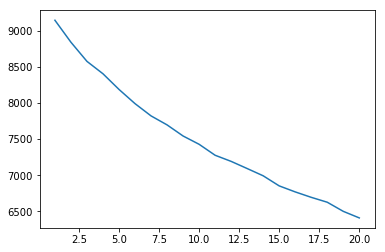

In [27]:
df_review_lsa = df_review_product_lsa[component_names]
# df_review_lsa = lsi_doc_vecs
plot_kmeans_inertia(df_review_lsa)

In [28]:
# TODO: Cluster on other product features, e.g. rating, price, 
number_review_clusters = 15
kmeans_reviews = KMeans(n_clusters=number_review_clusters)

# Cluster
review_lsa_clusters = kmeans_reviews.fit_predict(df_review_lsa)
cluster_to_review_ids = {}
for i in range(number_review_clusters):
    lsa_review_cluster = df_review_product_lsa.loc[review_lsa_clusters == i]['review_text']
    print('Cluster {} has {} reviews'.format(i, lsa_review_cluster.shape[0]))
    data_cluster_file = 'data/cluster_reviews/cluster_' + str(i) + '.txt'
    cluster_file = open(data_cluster_file, 'w') 
    for review_text in lsa_review_cluster.as_matrix():
        cluster_file.write(review_text + '\n')
    cluster_file.close()
    

Cluster 0 has 200 reviews
Cluster 1 has 435 reviews
Cluster 2 has 176 reviews
Cluster 3 has 2068 reviews
Cluster 4 has 904 reviews
Cluster 5 has 368 reviews
Cluster 6 has 315 reviews
Cluster 7 has 1492 reviews
Cluster 8 has 1766 reviews
Cluster 9 has 1161 reviews
Cluster 10 has 260 reviews
Cluster 11 has 265 reviews
Cluster 12 has 178 reviews
Cluster 13 has 204 reviews
Cluster 14 has 208 reviews


## K-Means Clustering of Products

In [29]:
df_review_lsa_product = df_review_product_lsa[component_names + ['product_id']].groupby(['product_id']).mean()
df_review_lsa_product.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
product_id,,,,,,,,,,,,,,,,,,,,,
P382355,0.131742,-0.075309,0.089642,-0.011619,0.096173,0.141711,0.056898,-0.018398,-0.073797,-0.048051,...,0.020616,0.030682,-0.004419,0.038861,-0.032145,0.041842,0.009539,-0.006173,0.080639,0.032301
P382356,0.139713,-0.021050,0.056099,-0.031958,0.079231,0.110624,0.023516,-0.015903,-0.058334,-0.006700,...,0.033604,-0.003201,0.017759,0.017958,0.013802,0.025643,0.058224,0.050286,0.009477,0.002383
P382968,0.149920,-0.155391,0.055775,-0.025975,0.071230,0.151041,0.073809,-0.036592,-0.028038,-0.007287,...,-0.006917,0.057367,-0.046814,0.010187,-0.038326,0.016856,-0.013593,0.037352,0.062912,0.017512
P382970,0.138559,-0.076429,0.068296,-0.026298,0.098351,0.136773,0.052835,-0.026056,-0.104241,0.006361,...,0.008343,0.008449,0.019816,0.057488,-0.009520,0.051142,0.031460,-0.004326,0.042080,0.046914
P383051,0.173680,-0.062344,0.083332,-0.044043,0.055433,0.104482,0.032603,-0.009323,-0.062038,-0.010468,...,0.020040,-0.016989,0.046231,0.064095,-0.012122,0.044895,0.027049,0.033381,0.056230,0.053832


In [30]:
df_review_lsa_product.shape

(138, 50)

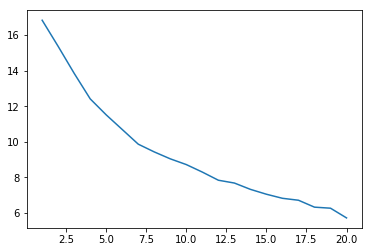

In [31]:
plot_kmeans_inertia(df_review_lsa_product)

In [33]:
# TODO: Cluster on other product features, e.g. rating, price, 
number_product_clusters = 15
kmeans_product_reviews = KMeans(n_clusters=number_product_clusters)

# Cluster
product_review_lsa_clusters = kmeans_product_reviews.fit_predict(df_review_lsa_product)
cluster_to_product_ids = {}

for i in range(number_product_clusters):
    
    lsa_product_components = df_review_lsa_product.loc[product_review_lsa_clusters == i]
    product_ids_for_cluster = lsa_product_components.index
    print('Product Cluster {} has {} products'.format(i, len(product_ids_for_cluster)))
    df_cluster_products = df_product.loc[product_ids_for_cluster]
    data_cluster_file = 'data/cluster_products/cluster_' + str(i) + '.txt'
    #os.remove(data_cluster_file)
    df_cluster_products.to_csv(data_cluster_file, mode = 'w')


Product Cluster 0 has 1 products
Product Cluster 1 has 20 products
Product Cluster 2 has 7 products
Product Cluster 3 has 21 products
Product Cluster 4 has 1 products
Product Cluster 5 has 3 products
Product Cluster 6 has 1 products
Product Cluster 7 has 16 products
Product Cluster 8 has 1 products
Product Cluster 9 has 1 products
Product Cluster 10 has 1 products
Product Cluster 11 has 1 products
Product Cluster 12 has 39 products
Product Cluster 13 has 24 products
Product Cluster 14 has 1 products


In [34]:
cluster_0 = df_review_lsa_product.loc[product_review_lsa_clusters == 0]
cluster_0.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
product_id,,,,,,,,,,,,,,,,,,,,,
P392253,0.204421,-0.168987,0.831371,-0.246261,-0.27752,-0.248564,-0.035951,0.055598,0.123841,0.042219,...,0.015492,-0.002135,-0.010005,-0.036154,-0.011571,0.012729,-0.036499,-0.043273,-0.015282,0.013491


In [35]:
df_product.loc[cluster_0.index]

,product_url,sku,category,brand,name,rating,detail_text,size_oz,price
product_id,,,,,,,,,
P392253,/greek-yoghurt-foaming-cream-cleanser-P392253,1674332,face wash & cleansers,KORRES,Greek Yoghurt Foaming Cream Cleanser,4.614,Which skin type is it good for? ✔ Normal ✔ Oil...,5.07,26


In [ ]:
# What kind of reviews are in Cluster 0?

## LDA

In [ ]:
"""
def print_unique_lda_topic_terms(lda_model, topic_count, id2word):
    term_to_topic_freq = {}
    for i in range(0, topic_count):
        term_ids = [id2word[term_id] for term_id, p in lda_model.get_topic_terms(i, topn=20)]
        for t in term_ids:
            curr_count = term_to_topic_freq.get(t, 0)
            term_to_topic_freq[t] = (curr_count + 1)
    for i in range(0, topic_count):
        print('Topic ', i)
        terms = [(id2word[term_id], p) for term_id, p in lda_model.get_topic_terms(i, topn=20) if term_to_topic_freq[id2word[term_id]] == 1]
        print(terms)
        
# Transpose it so the terms are the rows
lda_topic_count = 4
lda_doc_term_freq, lda_terms_to_freq, lda_id2term, lda_count_vectorizer = make_count_vectorizer(review_docs, (3, 3))

corpus = matutils.Sparse2Corpus(lda_doc_term_freq.transpose())

lda = models.LdaModel(corpus=corpus, num_topics=lda_topic_count, id2word=lda_id2term, passes=1)
print_unique_lda_topic_terms(lda, lda_topic_count, lda_id2term)
"""

In [ ]:
# lda.print_topics(num_words=20)

In [ ]:
# result = np.array([np.array([1, 2]), np.array([3, 4])])
# scale(result, with_mean=False)
# result